<a href="https://colab.research.google.com/github/NiyazovIlia/neural_networks/blob/lesson_6/neural_networks_lesson_6_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image
import tensorflow as tf


# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


In [6]:
import cv2

In [7]:
PAHT_label = '/content/drive/MyDrive/labes3/'
PAHT_image = '/content/drive/MyDrive/images3/'

In [8]:
import os, fnmatch
imag = os.listdir(PAHT_label)
imag_label = os.listdir(PAHT_image)

In [9]:
imag,imag_label

(['0190.png',
  '0200.png',
  '0197.png',
  '0119.png',
  '0052.png',
  '0141.png',
  '0124.png',
  '0031.png',
  '0135.png',
  '0123.png',
  '0032.png',
  '0064.png',
  '0199.png',
  '0138.png',
  '0131.png',
  '0184.png',
  '0181.png',
  '0033.png',
  '0194.png',
  '0091.png',
  '0055.png',
  '0167.png',
  '0129.png',
  '0102.png',
  '0108.png',
  '0009.png',
  '0198.png',
  '0186.png',
  '0157.png',
  '0095.png',
  '0001.png',
  '0087.png',
  '0045.png',
  '0061.png',
  '0043.png',
  '0130.png',
  '0077.png',
  '0170.png',
  '0063.png',
  '0040.png',
  '0037.png',
  '0161.png',
  '0166.png',
  '0179.png',
  '0114.png',
  '0038.png',
  '0158.png',
  '0082.png',
  '0088.png',
  '0044.png',
  '0065.png',
  '0093.png',
  '0068.png',
  '0126.png',
  '0187.png',
  '0012.png',
  '0053.png',
  '0191.png',
  '0155.png',
  '0067.png',
  '0149.png',
  '0026.png',
  '0056.png',
  '0066.png',
  '0005.png',
  '0016.png',
  '0160.png',
  '0159.png',
  '0069.png',
  '0078.png',
  '0094.png',
  '001

In [10]:
images = []
segments = []
image_size = (200,600)
for i_name in imag:
  images.append(image.load_img(PAHT_image+i_name ,target_size=image_size))
  segments.append(image.load_img(PAHT_label+i_name, target_size=image_size))

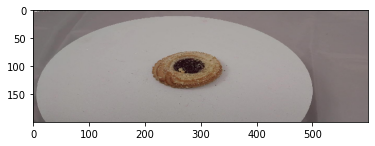

In [11]:
plt.imshow(images[0].convert('RGBA'))
plt.show()

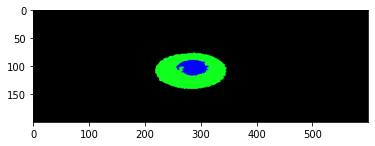

In [12]:
plt.imshow(segments[0].convert('RGBA'))
plt.show()

In [13]:
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

In [14]:
print(xTrain_Test.shape)

(200, 200, 600, 3)


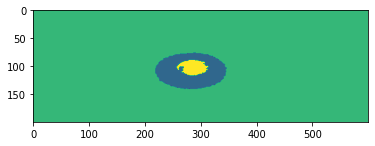

In [15]:
def Color2index(y):
  arr_col=[[17,255,31],[0,0,0], [0,4,255]]
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
  
  return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show()  


In [16]:
yTrain_Test = []

for seg in segments:
  y_cat,_,_ = Color2index(image.img_to_array(seg))
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

In [17]:
print(yTrain_Test.shape)

(200, 200, 600, 3)


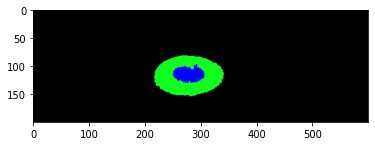

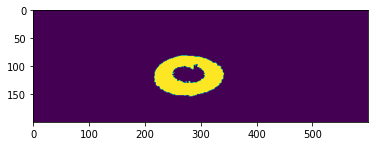

In [18]:
n = 10
plt.imshow(segments[n].convert('RGBA'))
plt.show()
img = yTrain_Test[n][:,:,0]
plt.imshow(img.astype(float))
plt.show()

In [19]:
end = 50
start = 150
yTrain = yTrain_Test[:end,:,:,:]
xTrain = xTrain_Test[:end,:,:,:]

yTest = yTrain_Test[start:,:,:,:]
xTest = xTrain_Test[start:,:,:,:]

In [20]:
yTest.shape

(50, 200, 600, 3)

In [21]:
print(xTrain.shape)
print(yTrain.shape)

(50, 200, 600, 3)
(50, 200, 600, 3)


In [22]:
from tensorflow.keras.utils import plot_model

In [23]:
def Unet(num_classes = 3, input_shape= (200, 600, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 100x300

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) # 50x150

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) #25x75

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    #x = MaxPooling2D()(block_4_out)

    # Block 5
    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    #x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = concatenate([x, block_4_out])
    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #50x150
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [24]:
modelC = Unet(3, (200, 600, 3))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 600, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 600, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 200, 600, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

In [ ]:
history = modelC.fit(xTrain, yTrain, epochs=10, batch_size=1, validation_data=(xTrain, yTrain))

Epoch 1/10
50/50 [==============================] - 616s 12s/step - loss: 0.1229 - dice_coef: 0.9284 - val_loss: 2848.6382 - val_dice_coef: 0.0190
Epoch 2/10
50/50 [==============================] - 622s 12s/step - loss: 0.0470 - dice_coef: 0.9712 - val_loss: 187.1945 - val_dice_coef: 0.0138
Epoch 3/10
30/50 [=================>............] - ETA: 3:17 - loss: 0.0468 - dice_coef: 0.9706

In [ ]:
pred = modelC.predict(xTest)
print(pred.shape)

In [ ]:
n = 1
class_ =0
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()